# Capstone

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np



### Dataset 
We’re working with the NYC Yellow Taxi Trip Records—millions of rides stored in parquet format.  
Here, I glance at the features and records before any wrangling.

In [5]:
# Load datasets

url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-06.parquet"
lookup = pd.read_csv("taxi_zone_lookup.csv")
lookup = lookup[['LocationID', 'Borough']].copy()

f_file = pd.read_parquet(url)
f_file['sum_amount'] = (
    f_file['fare_amount']
    + f_file['extra']
    + f_file['mta_tax']
    + f_file['tolls_amount']
    + f_file['improvement_surcharge']
    + f_file['congestion_surcharge']
    + f_file['Airport_fee']
)



print(f_file['PULocationID'].min(), f_file['DOLocationID'].max())
f_file.info()

# f_file['mta_tax'].isnull().value_counts()

print('\n')
print(f_file['mta_tax'].unique())
# f_file[['payment_type' == 1]['tip_amount']]
# f_file[f_file['mta_tax'] == 25]['trip_distance']
# print(f_file['fare_amount'][f_file['total_amount'] < 0])
print('\n')
# print(len(f_file[f_file['total_amount'] < 0]))


1 265
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3539193 entries, 0 to 3539192
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee     

In [6]:

# Inspect datetime granularity
f_file['year'] = f_file['tpep_pickup_datetime'].dt.year
f_file['month'] = f_file['tpep_pickup_datetime'].dt.month
f_file['day'] = f_file['tpep_pickup_datetime'].dt.day
f_file['hour'] = f_file['tpep_pickup_datetime'].dt.hour
f_file['weekday'] = f_file['tpep_pickup_datetime'].dt.day_name()
f_file['pickup_date'] = f_file['tpep_pickup_datetime'].dt.date
f_file['dropoff_date'] = f_file['tpep_dropoff_datetime'].dt.date

f_file['trip_time_min'] = (f_file['tpep_dropoff_datetime'] - f_file['tpep_pickup_datetime']).dt.total_seconds() / 60
f_file = f_file[f_file['year'] == 2024].copy()



# --- 1. Attach boroughs if not already present (trust taxi_zone_lookup.csv) ---

if 'Pickup_Borough' not in f_file.columns or 'Dropoff_Borough' not in f_file.columns:

    # pickup borough
    f_file = f_file.merge(
        lookup.rename(columns={'Borough': 'Pickup_Borough'}),
        left_on='PULocationID', right_on='LocationID', how='left'
    ).drop(columns=['LocationID'])

    # dropoff borough
    f_file = f_file.merge(
        lookup.rename(columns={'Borough': 'Dropoff_Borough'}),
        left_on='DOLocationID', right_on='LocationID', how='left'
    ).drop(columns=['LocationID'])


    # --- 2. Daily total rides (one number per pickup_date) ---
    
    daily_rides = (
        f_file.groupby('pickup_date')
        .size()
        .reset_index(name='daily_ride_count')
    )
    
    # merge back so every row knows its day's total rides
    f_file = f_file.merge(daily_rides, on='pickup_date', how='left')
    
    
    # --- 3. Daily pickup-borough proportions ---
    
    # count rides per day per pickup borough
    daily_borough = (
        f_file.groupby(['pickup_date', 'Pickup_Borough'])
        .size()
        .reset_index(name='pu_borough_daily_count')
    )
    
    # bring in the day's total rides
    daily_borough = daily_borough.merge(daily_rides, on='pickup_date', how='left')
    
    # proportion of that day's rides that start in each borough
    daily_borough['pu_borough_daily_prop'] = (
        daily_borough['pu_borough_daily_count'] / daily_borough['daily_ride_count']
    )
    
    # merge these borough metrics back into f_file
    f_file = f_file.merge(
        daily_borough[['pickup_date', 'Pickup_Borough',
                       'pu_borough_daily_count', 'pu_borough_daily_prop']],
        on=['pickup_date', 'Pickup_Borough'],
        how='left'
    )
    
    
    # --- 5. Daily inter-borough movement (count + proportion) ---
    
    # flag inter-borough trips
    f_file['is_interborough'] = (
        f_file['Pickup_Borough'] != f_file['Dropoff_Borough']
    ).astype(int)
    
    daily_interborough = (
        f_file.groupby('pickup_date')['is_interborough']
        .sum()
        .reset_index(name='daily_interborough_count')
    )
    
    daily_interborough = daily_interborough.merge(daily_rides, on='pickup_date', how='left')
    daily_interborough['daily_interborough_prop'] = (
        daily_interborough['daily_interborough_count'] /
        daily_interborough['daily_ride_count']
    )
    
    # merge back into f_file
    f_file = f_file.merge(
        daily_interborough[['pickup_date',
                            'daily_interborough_count',
                            'daily_interborough_prop']],
        on='pickup_date',
        how='left'
    )
    
    
    # --- 6. Daily trip time summaries (for EDA and possible modeling later) ---
    
    daily_trip_time = (
        f_file.groupby('pickup_date')['trip_time_min']
        .agg(daily_mean_trip_time='mean',
             daily_median_trip_time='median',
             daily_min_trip_time='min',
             daily_max_trip_time='max')
        .reset_index()
    )
    
    f_file = f_file.merge(daily_trip_time, on='pickup_date', how='left')



print(f_file.columns)
print(daily_trip_time)

print(daily_rides)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'sum_amount',
       'year', 'month', 'day', 'hour', 'weekday', 'pickup_date',
       'dropoff_date', 'trip_time_min', 'Pickup_Borough', 'Dropoff_Borough',
       'daily_ride_count', 'pu_borough_daily_count', 'pu_borough_daily_prop',
       'is_interborough', 'daily_interborough_count',
       'daily_interborough_prop', 'daily_mean_trip_time',
       'daily_median_trip_time', 'daily_min_trip_time', 'daily_max_trip_time'],
      dtype='object')
   pickup_date  daily_mean_trip_time  daily_median_trip_time  \
0   2024-05-31             78.629762               10.141667   
1   2024-06-01             16.776787               12.766667   

## Exploratory Data Analysis

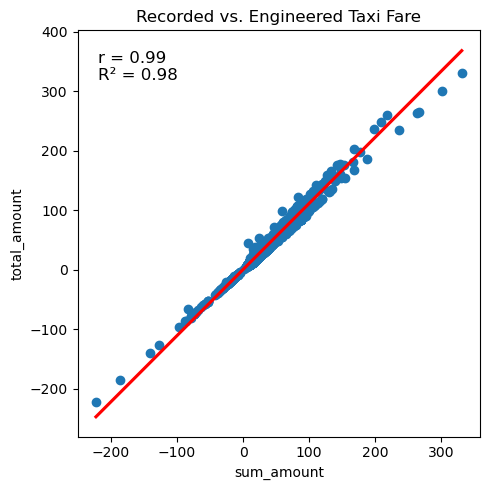

In [8]:
# --- Checking fare consistency ---
# Scatter plot of recorded total_amount vs engineered sum_amount with regression line.

# --- Checking fare consistency ---

# 1. Drop rows with NaN in either sum_amount or total_amount
fare_df = f_file[['sum_amount', 'total_amount']].dropna()

# 2. Sample AFTER dropping NaN
sample_df = fare_df.sample(10000, random_state=0)

# 3. Plot
plt.figure(figsize=(5,5))
sns.regplot(
    x='sum_amount',
    y='total_amount',
    data=sample_df,
    color='blue',
    scatter_kws={'color': '#1f77b4', 'alpha': 1},
    line_kws={'color': 'red'}
)

# 4. Correlation and OLS (both now NaN-safe)
corr = fare_df['sum_amount'].corr(fare_df['total_amount'])

ols_model = sm.OLS(
    fare_df['total_amount'], 
    sm.add_constant(fare_df['sum_amount'])
).fit()

plt.text(
    0.05, 0.95,
    f"r = {corr:.2f}\nR² = {ols_model.rsquared:.2f}",
    transform=plt.gca().transAxes,
    ha='left', va='top', fontsize=12
)

plt.title("Recorded vs. Engineered Taxi Fare")
plt.tight_layout()

fig = plt.gcf()
fig.savefig("fare_discrepancy.png", dpi=300, bbox_inches="tight")
plt.show()



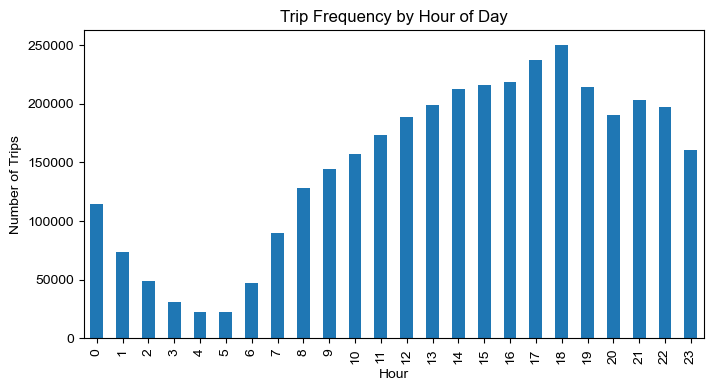

In [11]:

# Checking hourly trip tally for rush-hour
hourly_count = f_file.groupby('hour')['tpep_pickup_datetime'].count()

plt.figure(figsize = (8, 4))
hourly_count.plot(kind = 'bar')
plt.title('Trip Frequency by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')

fig = plt.gcf()
fig.savefig("rush-hour.png", dpi=300, bbox_inches="tight")

plt.show()

### Fare distribution

Cursory overlook of price distribution in NYC.

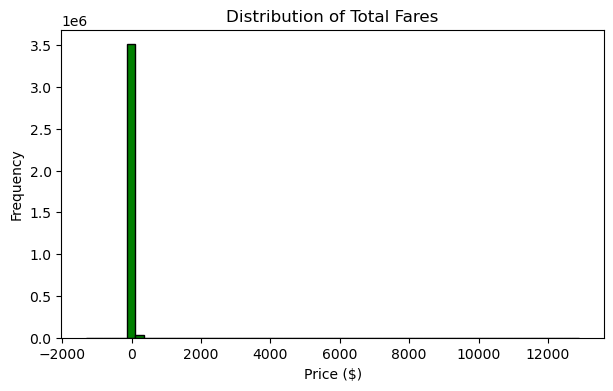

In [7]:
# Chart for realistic fare range following the trim

plt.figure(figsize=(7,4))
plt.hist(f_file['total_amount'], bins=60, color='green', edgecolor='black')
plt.title('Distribution of Total Fares')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()


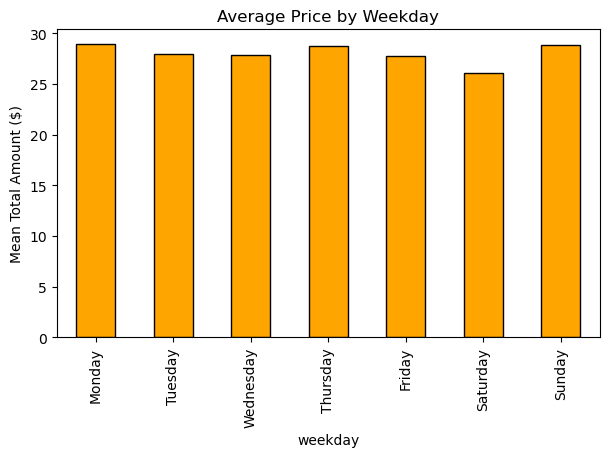

In [8]:
# Spending behaviour by day 

weekday_fare = f_file.groupby('weekday')['total_amount'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
weekday_fare.plot(kind='bar', color='orange', edgecolor='black', figsize=(7,4))
plt.title('Average Price by Weekday')
plt.ylabel('Mean Total Amount ($)')
plt.show()


### Travel distribution

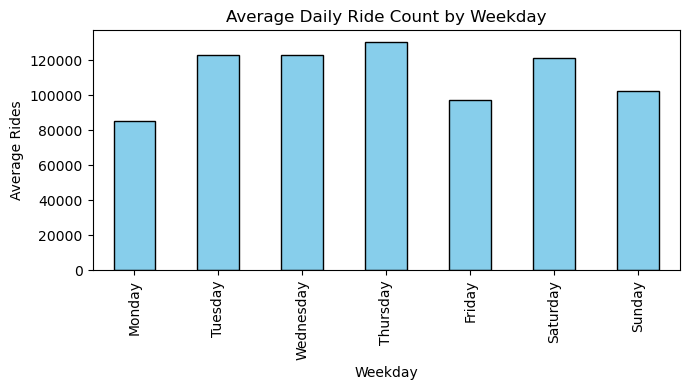

In [9]:
daily_weekday = (
    f_file[['pickup_date', 'weekday', 'daily_ride_count']]
    .drop_duplicates(subset=['pickup_date'])
)

weekday_rides = (
    daily_weekday
    .groupby('weekday')['daily_ride_count']
    .mean()
    .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
)

weekday_rides.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(7,4))
plt.title('Average Daily Ride Count by Weekday')
plt.ylabel('Average Rides')
plt.xlabel('Weekday')
plt.tight_layout()
plt.show()


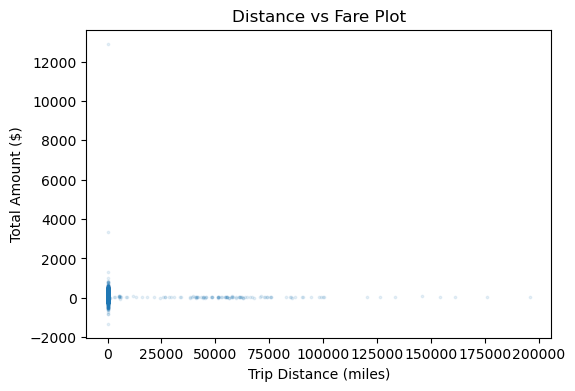

In [10]:
# Distance against price trends

plt.figure(figsize=(6,4))
plt.scatter(f_file['trip_distance'], f_file['total_amount'], alpha=0.1, s=3)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Total Amount ($)')
plt.title('Distance vs Fare Plot')
plt.show()


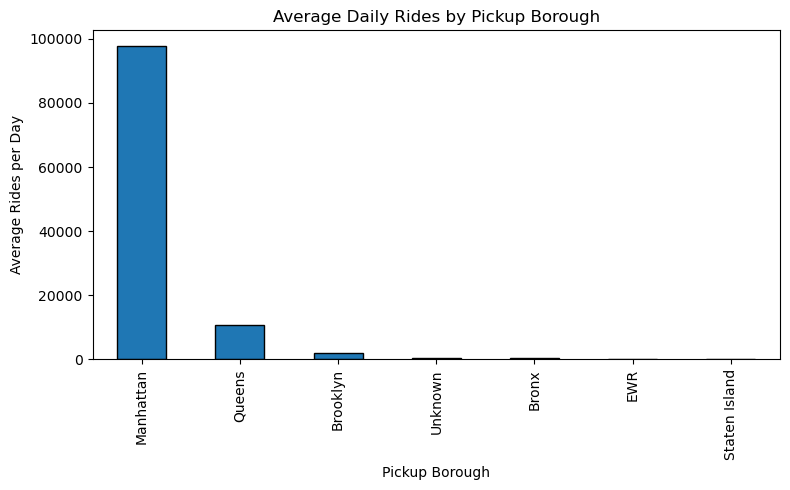

In [11]:
# one row per day+borough
daily_boro = (
    f_file[['pickup_date', 'Pickup_Borough', 'pu_borough_daily_count']]
    .drop_duplicates()
)

# average daily rides per borough
avg_daily_rides = (
    daily_boro
    .groupby('Pickup_Borough')['pu_borough_daily_count']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
avg_daily_rides.plot(kind='bar', edgecolor='black')
plt.title("Average Daily Rides by Pickup Borough")
plt.xlabel("Pickup Borough")
plt.ylabel("Average Rides per Day")
plt.tight_layout()
plt.show()

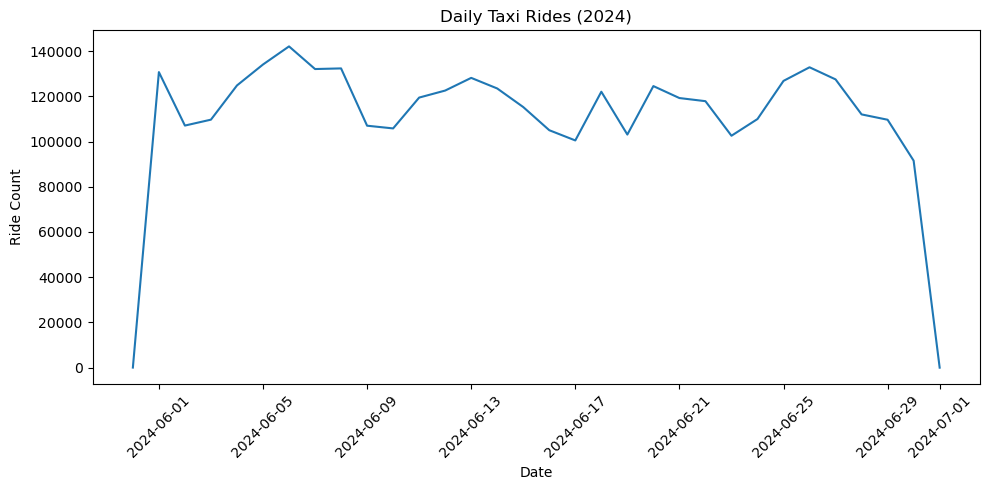

In [12]:

# Ride Count Distribution

plt.figure(figsize=(10,5))
plt.plot(daily_rides['pickup_date'], daily_rides['daily_ride_count'])
plt.title("Daily Taxi Rides (2024)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


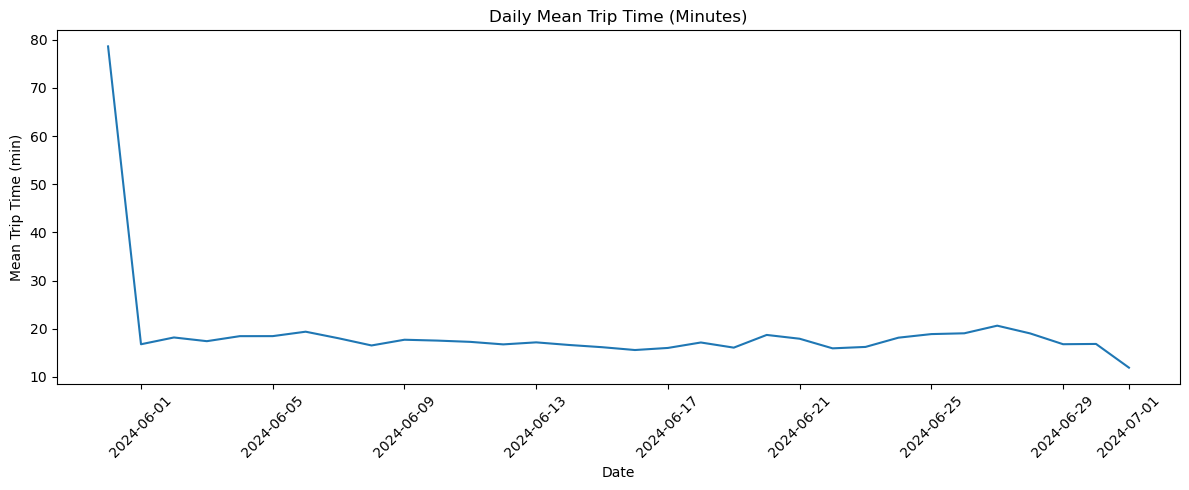

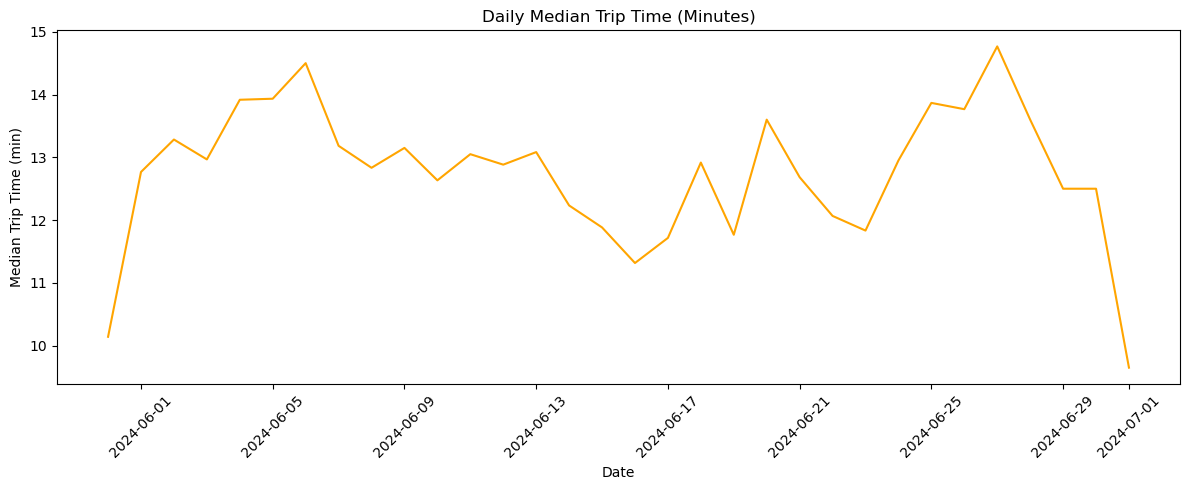

   pickup_date  daily_mean_trip_time  daily_median_trip_time  \
6   2024-06-06             19.384925               14.500000   
27  2024-06-27             20.635862               14.766667   
15  2024-06-15             16.167706               11.883333   
30  2024-06-30             16.841932               12.500000   
7   2024-06-07             18.016372               13.183333   
28  2024-06-28             19.026361               13.600000   
19  2024-06-19             16.075036               11.766667   
14  2024-06-14             16.626650               12.233333   
13  2024-06-13             17.169743               13.083333   
29  2024-06-29             16.785677               12.500000   

    daily_min_trip_time  daily_max_trip_time  
6             -9.600000          7658.633333  
27             0.000000          5451.866667  
15           -18.166667          5190.283333  
30             0.000000          5081.666667  
7            -22.016667          4380.766667  
28           

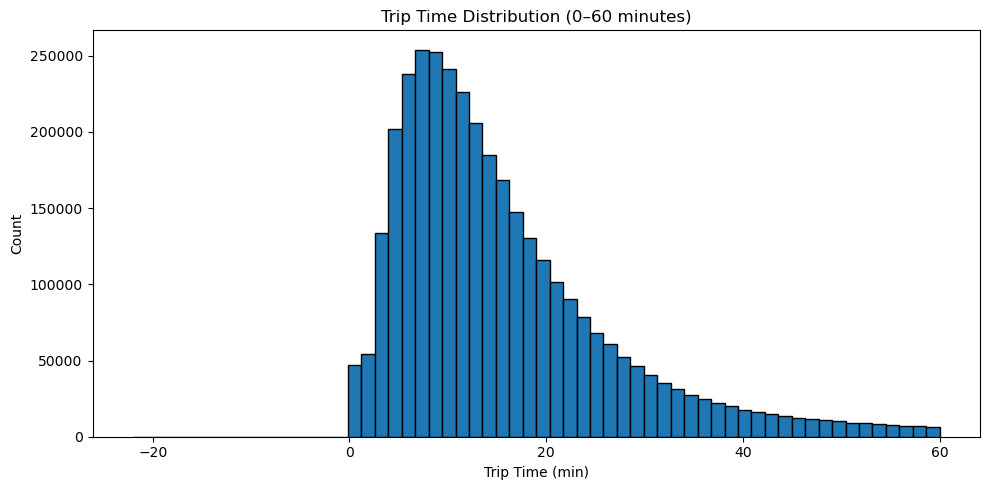

In [13]:

# Trip-Time aggregations Distributions

plt.figure(figsize=(12,5))
plt.plot(daily_trip_time['pickup_date'], daily_trip_time['daily_mean_trip_time'])
plt.title("Daily Mean Trip Time (Minutes)")
plt.xlabel("Date")
plt.ylabel("Mean Trip Time (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(daily_trip_time['pickup_date'], daily_trip_time['daily_median_trip_time'], color='orange')
plt.title("Daily Median Trip Time (Minutes)")
plt.xlabel("Date")
plt.ylabel("Median Trip Time (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# print(daily_trip_time.sort_values('daily_max_trip_time', ascending=False).head(10))


plt.figure(figsize=(10,5))
f_file[f_file['trip_time_min'] <= 60]['trip_time_min']\
    .plot(kind='hist', bins=60, edgecolor='black')
plt.title("Trip Time Distribution (0–60 minutes)")
plt.xlabel("Trip Time (min)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


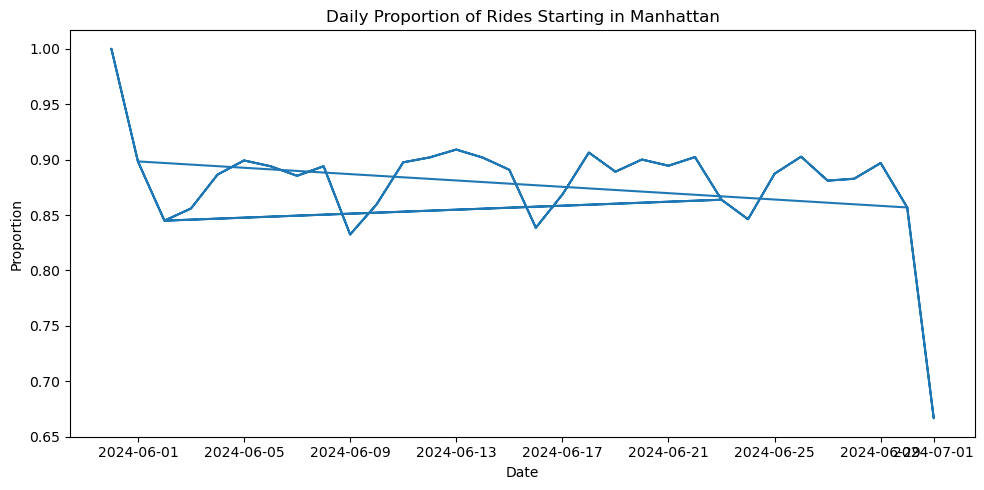

In [14]:
manhattan_prop = f_file[f_file['Pickup_Borough'] == 'Manhattan']

plt.figure(figsize=(10,5))
plt.plot(
    manhattan_prop['pickup_date'],
    manhattan_prop['pu_borough_daily_prop']
)
plt.title("Daily Proportion of Rides Starting in Manhattan")
plt.xlabel("Date")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()


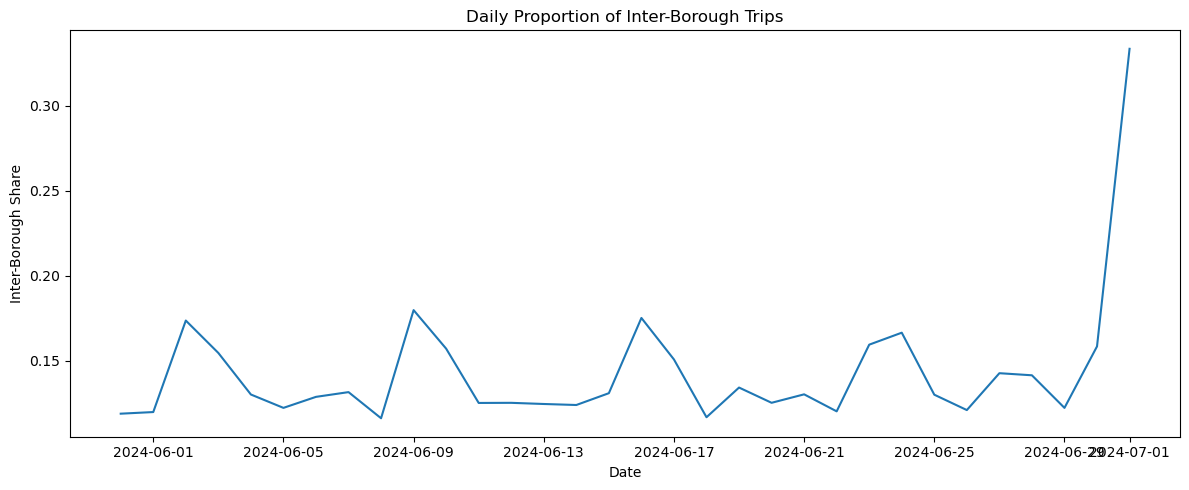

In [15]:
plt.figure(figsize=(12,5))
plt.plot(daily_interborough['pickup_date'], 
         daily_interborough['daily_interborough_prop'])
plt.title("Daily Proportion of Inter-Borough Trips")
plt.xlabel("Date")
plt.ylabel("Inter-Borough Share")
plt.tight_layout()
plt.show()


## Data Preparation

In [16]:


# Trim price; drop trips with wayward distance and duration
f_file = f_file[
    (f_file['total_amount'].between(5.99, 250)) &
    (f_file['trip_distance'].between(.1, 25)) &
    (f_file['trip_time_min'].between(1, 100))
]


# Sort to make sure chronological
f_file = f_file.sort_values('tpep_pickup_datetime').reset_index(drop=True)


# Fill passenger_count missing with 1 (NYC default)
f_file['passenger_count'] = f_file['passenger_count'].fillna(1)

# Target for Model 3
f_file['multi_passenger'] = (f_file['passenger_count'] > 1).astype(int)






## Model Training & Validation

### Model 1 -- Trip Duration (Linear Regression)

In [17]:

features_time = [
    'hour',
    'weekday',
    'trip_distance',
    'Pickup_Borough',
    'Dropoff_Borough',
    'total_amount',
    'passenger_count'
]

X_time = pd.get_dummies(f_file[features_time], drop_first=True)
# X_time = X_time.fillna(0)
y_time = f_file['trip_time_min']

X_train, X_test, y_train, y_test = train_test_split(
    X_time, y_time, test_size=0.2, random_state=42
)

lr_time = LinearRegression().fit(X_train, y_train)
pred_time = lr_time.predict(X_test)

print("Trip Time MAE:", mean_absolute_error(y_test, pred_time))
print("Trip Time RMSE:", np.sqrt(mean_squared_error(y_test, pred_time)))


Trip Time MAE: 4.2823279494398845
Trip Time RMSE: 6.7487586048395665


### Model 2 -- Fare Amount (Linear Regression)

In [18]:

features_fare = [
    'hour',
    'weekday',
    'trip_distance',
    'Pickup_Borough',
    'Dropoff_Borough',
    'trip_time_min',
    'passenger_count'
]

X_fare = pd.get_dummies(f_file[features_fare], drop_first=True)
y_fare = f_file['total_amount']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fare, y_fare, test_size=0.2, random_state=42
)

lr_fare = LinearRegression().fit(X_train_f, y_train_f)
pred_fare = lr_fare.predict(X_test_f)

print("Fare MAE:", mean_absolute_error(y_test_f, pred_fare))
print("Fare RMSE:", np.sqrt(mean_squared_error(y_test_f, pred_fare)))


Fare MAE: 3.4293484710618234
Fare RMSE: 6.2800014049877255


### Model 3 -- Likelihood of >1 passenger (Logistic Regression)

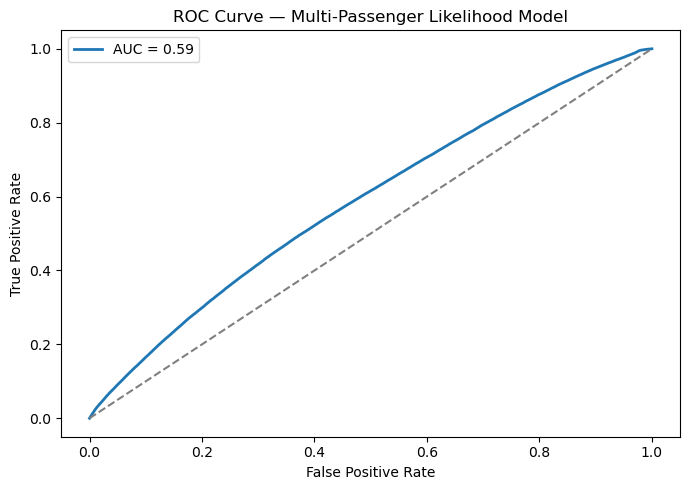

In [25]:

features_pass = [
    'hour',
    'weekday',
    'Pickup_Borough',
    'Dropoff_Borough',
    'trip_distance',
    'trip_time_min',
    'total_amount'
]

# One-hot encode categorical fields
X_pass = pd.get_dummies(f_file[features_pass], drop_first=True)
y_pass = f_file['multi_passenger']

# Train Test split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_pass, y_pass, test_size=0.2, random_state=42
)

# Fit scaler on training data ONLY
scaler = StandardScaler() 
scaler.fit(X_train_p) 

# Transform feature data using scaler scaled on the train set only
X_train_scaled = scaler.transform(X_train_p) 
X_test_scaled = scaler.transform(X_test_p)

# Fit model
logit = LogisticRegression(max_iter=70).fit(X_train_scaled, y_train_p)
logit.fit(X_train_scaled, y_train_p)

# Predict probabilities
pred_prob = logit.predict_proba(X_test_scaled)[:,1]



# ROC curve
fpr, tpr, _ = roc_curve(y_test_p, pred_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Multi-Passenger Likelihood Model")
plt.legend(loc="upper left")
plt.tight_layout()

# Save figure
fig = plt.gcf()
fig.savefig("multi_passenger_roc.png", dpi=300, bbox_inches="tight")

plt.show()